## Notebook to prepare data  
- Prepare data in suitable format for the model training in Vertex AI Model Garden  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import datetime as dt

print(f"Successfully imported libraries at {dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Successfully imported libraries at 2025-08-17 10:58:30


In [3]:
df = pd.read_csv("data/iris_combined.csv")
df.shape, df.columns, df.head()

((300, 7),
 Index(['flower_id', 'event_timestamp', 'species', 'sepal_length',
        'sepal_width', 'petal_length', 'petal_width'],
       dtype='object'),
    flower_id            event_timestamp    species  sepal_length  sepal_width  \
 0        110  2023-12-31 23:59:59+00:00  virginica           6.8          3.0   
 1        105  2023-12-31 23:59:59+00:00  virginica           6.7          3.3   
 2         20  2023-12-31 23:59:59+00:00     setosa           4.6          3.2   
 3        132  2023-12-31 23:59:59+00:00  virginica           6.9          3.1   
 4          1  2023-12-31 23:59:59+00:00     setosa           4.6          3.6   
 
    petal_length  petal_width  
 0           5.5          2.1  
 1           5.7          2.5  
 2           1.4          0.2  
 3           5.4          2.1  
 4           1.0          0.2  )

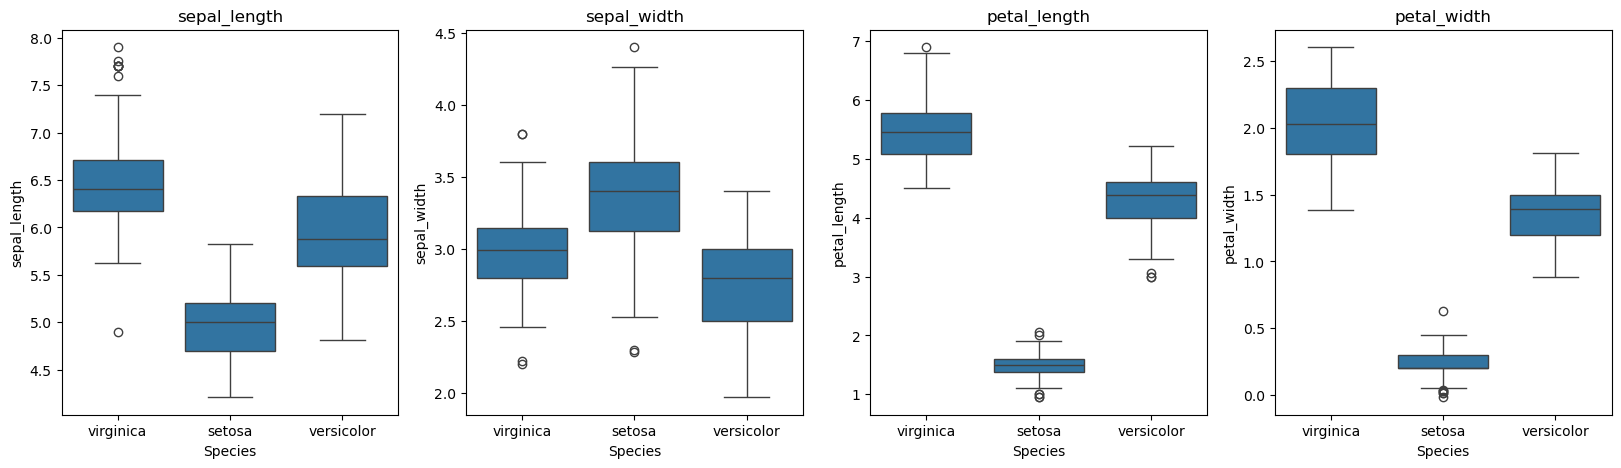

In [9]:
# Create box plots of each feature by species in same figure in single row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width']):
    sns.boxplot(x='species', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Species')
    axes[i].set_ylabel(col)

In [11]:
# Define a function to bin featues into three groups based on cutoff level provided as a dictionary
# for eg. cutoff_levels = {'sepal_length': [5.0, 6.5], 'sepal_width': [2.5, 3.5], 'petal_length': [1.5, 4.0], 'petal_width': [0.2, 1.0]}
# Create four new bins based on the cutoff levels
def categorize_feature(df, cutoff_levels):
    for feature, levels in cutoff_levels.items():
        df[f'{feature}_bin_v1'] = pd.cut(df[feature], bins=[-np.inf] + levels + [np.inf], labels=['small', 'medium', 'large'])
    return df

In [13]:
df_bins_v1 = categorize_feature(df.copy(), {
    'sepal_length': [5.3, 6.5],
    'sepal_width': [3.0, 3.5],
    'petal_length': [2.5, 4.5],
    'petal_width': [0.7, 1.8]
})
df_bins_v1.shape, df_bins_v1.columns, df_bins_v1.head()

((300, 11),
 Index(['flower_id', 'event_timestamp', 'species', 'sepal_length',
        'sepal_width', 'petal_length', 'petal_width', 'sepal_length_bin_v1',
        'sepal_width_bin_v1', 'petal_length_bin_v1', 'petal_width_bin_v1'],
       dtype='object'),
    flower_id            event_timestamp    species  sepal_length  sepal_width  \
 0        110  2023-12-31 23:59:59+00:00  virginica           6.8          3.0   
 1        105  2023-12-31 23:59:59+00:00  virginica           6.7          3.3   
 2         20  2023-12-31 23:59:59+00:00     setosa           4.6          3.2   
 3        132  2023-12-31 23:59:59+00:00  virginica           6.9          3.1   
 4          1  2023-12-31 23:59:59+00:00     setosa           4.6          3.6   
 
    petal_length  petal_width sepal_length_bin_v1 sepal_width_bin_v1  \
 0           5.5          2.1               large              small   
 1           5.7          2.5               large             medium   
 2           1.4          0.2     

In [15]:
# Convert the new features into a jsonl format like below
# {"messages": [{"role": "system", "content": "Classify the flower based on its measurements into one of the following species: [Setosa, Versicolor, Virginica]"}, {"role": "user", "content": "Sepal Length: medium, Sepal Width: medium, Petal Length: small, Petal Width: small"}, {"role": "assistant", "content": "Setosa"}]}
def create_jsonl(df, output_file):
    with open(output_file, 'w') as f:
        for _, row in df.iterrows():
            message = {
                "messages": [
                    {"role": "system", "content": "Classify the flower based on its measurements into one of the following species: [Setosa, Versicolor, Virginica]"},
                    {"role": "user", "content": f"Sepal Length: {row['sepal_length_bin_v1']}, Sepal Width: {row['sepal_width_bin_v1']}, Petal Length: {row['petal_length_bin_v1']}, Petal Width: {row['petal_width_bin_v1']}"},
                    {"role": "assistant", "content": row['species']}
                ]
            }
            f.write(json.dumps(message) + '\n')

In [17]:
# Split the data into train and test sets  
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_bins_v1, test_size=0.2, random_state=42, stratify=df_bins_v1['species'])
train_df.shape, test_df.shape

((240, 11), (60, 11))

In [18]:
create_jsonl(train_df, 'data/iris_binned_v1_train.jsonl')
create_jsonl(test_df, 'data/iris_binned_v1_test.jsonl')

In [19]:
# Convert the new features into a jsonl format like below
# {"input_text": "Classify the flower based on its measurements into one of the following species: [Setosa, Versicolor, Virginica] Text: "Sepal Length: medium, Sepal Width: medium, Petal Length: small, Petal Width: small", "output_text": "versicolor"}
def create_jsonl_v2(df, output_file):
    with open(output_file, 'w') as f:
        for _, row in df.iterrows():
            message = {
                "input_text": "Classify the flower based on its measurements into one of the following species: [Setosa, Versicolor, Virginica] Text: "
                              f"Sepal Length: {row['sepal_length_bin_v1']}, Sepal Width: {row['sepal_width_bin_v1']}, "
                              f"Petal Length: {row['petal_length_bin_v1']}, Petal Width: {row['petal_width_bin_v1']}",
                "output_text": row['species']
            }
            f.write(json.dumps(message) + '\n')

In [20]:
create_jsonl_v2(train_df, 'data/iris_binned_v2_train.jsonl')
create_jsonl_v2(test_df, 'data/iris_binned_v2_test.jsonl')